# Image Classification - Lab

## Introduction

Now that you have a working knowledge of CNNs and have practiced implementing associated techniques in Keras, its time to put all of those skills together. In this lab, you'll work to complete a [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification) on classifying dog breeds.


## Objectives

In this lab you will: 

- Compare and apply multiple techniques for tuning a model using data augmentation and pretrained models  

## Download and Load the Data

Start by downloading the data locally and loading it into a Pandas DataFrame. Be forewarned that this dataset is fairly large and it is advisable to close other memory intensive applications.

The data can be found [here](https://www.kaggle.com/c/dog-breed-identification/data).

It's easiest if you download the data into this directory on your local computer. From there, be sure to uncompress the folder and subfolders. If you download the data elsewhere, be sure to modify the file path when importing the file below.

In [1]:
# No code per se, but download and decompress the data

## Preprocessing

Now that you've downloaded the data, its time to prepare it for some model building! You'll notice that the current structure provided is not the same as our lovely preprocessed folders that you've been given to date. Instead, you have one large training folder with images and a csv file with labels associated with each of these file types. 

Use this to create a directory substructure for a train-validation-test split as we have done previously. Also recall that you'll also want to use one-hot encoding as you are now presented with a multi-class problem as opposed to simple binary classification.

In [1]:
import pandas as pd

In [ ]:
ls

In [2]:
df = pd.read_csv('dog_breeds/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
ls dog_breeds/train/ | head -5


In order to input the data into our standard pipeline, you'll need to organize the image files into a nested folder structure. At the top level will be a folder for the training data, a folder for the validation data, and a folder for the test data. Within these top directory folders, you'll then need to create a folder for each of the categorical classes (in this case, dog breeds). Finally, within these category folders you'll then place each of the associated image files. To save time, do this for just 3 of the dog breeds such as `'boston_bull'`, `'toy_poodle'`, and `'scottish_deerhound'`.

You're nested file structure should look like this:
* train
    * category_1
    * category_2
    * category_3
    ...
* val
    * category_1
    * category_2
    * category_3
    ...
* test 
    * category_1
    * category_2
    * category_3
    ...  

> **Hint**: To do this, you can use the `os` module which will you can use to execute many common bash commands straight from your python interpreter. For example, here's how you could make a new folder: 

```python
import os
os.mkdir('New_Folder_Name')
```
Start by creating top level folders for the train, validation, and test sets. Then, use your pandas DataFrame to split the example images for each breed of dog into a 80% train set, and 10% validation and test sets. Use `os.path.join()` with the information from the DataFrame to construct the relevant file path. With this, place the relevant images using the `shutil.copy()` into the appropriate directory. 

>> **Note**: It is worthwhile to try this exercise on your own, but you can also use the images stored under the `'data_org_subset/'` folder of this repository, in which the Kaggle dataset has already been subset and preprocessed.

In [8]:
print('Number of unique breeds:', df.breed.nunique())
print(df.breed.value_counts()[:10])

Number of unique breeds: 120
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64


In [49]:
import numpy as np
import os, shutil

old_dir = 'dog_breeds/train/'

new_root_dir = 'data_org_subset/'
# Because this cell has already been run and this directory now exists, running this cell again will throw an error
os.mkdir(new_root_dir) 

dir_names = ['train', 'val', 'test']
for d in dir_names:
    new_dir = os.path.join(new_root_dir, d)
    os.mkdir(new_dir)
    
for breed in ['boston_bull', 'toy_poodle', 'scottish_deerhound']:
    print('Moving {} pictures.'.format(breed))
    # Create sub_directories
    for d in dir_names:
        new_dir = os.path.join(new_root_dir, d, breed)
        os.mkdir(new_dir)
    # Subset dataframe into train, validate and split sets
    # Split is performed here to ensure maintain class distributions.
    temp = df[df.breed == breed]
    train, validate, test = np.split(temp.sample(frac=1), [int(.8*len(temp)), int(.9*len(temp))])
    print('Split {} imgs into {} train, {} val, and {} test examples.'.format(len(temp),
                                                                              len(train),
                                                                              len(validate),
                                                                              len(test)))
    for i, temp in enumerate([train, validate, test]):
        for row in temp.index:
            filename = temp['id'][row] + '.jpg'
            origin = os.path.join(old_dir + filename)
            destination = os.path.join(new_root_dir + dir_names[i] + '/' + breed + '/' + filename)
            shutil.copy(origin, destination)

Moving boston_bull pictures.
Split 87 imgs into 69 train, 9 val, and 9 test examples.
Moving toy_poodle pictures.
Split 80 imgs into 64 train, 8 val, and 8 test examples.
Moving scottish_deerhound pictures.
Split 126 imgs into 100 train, 13 val, and 13 test examples.


In [50]:
# Your code here
from keras.preprocessing.image import ImageDataGenerator

train_dir = '{}train'.format(new_root_dir)

validation_dir = '{}val/'.format(new_root_dir)
test_dir = '{}test/'.format(new_root_dir)

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=20, 
                                                        class_mode='categorical')

Found 233 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [51]:
train_generator.class_indices

{'boston_bull': 0, 'scottish_deerhound': 1, 'toy_poodle': 2}

## Optional: Build a Baseline CNN

This is an optional step. Adapting a pretrained model will produce better results, but it may be interesting to create a CNN from scratch as a baseline. If you wish to, do so here.

In [31]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [54]:
from keras import layers
from keras import models
from keras import optimizers
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=50)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
100/100 [==============================] - 74s 743ms/step - loss: 1.0056 - acc: 0.4945 - val_loss: 0.8694 - val_acc: 0.6000
Epoch 2/10
100/100 [==============================] - 73s 727ms/step - loss: 0.7334 - acc: 0.6899 - val_loss: 1.1696 - val_acc: 0.5667
Epoch 3/10
100/100 [==============================] - 73s 728ms/step - loss: 0.5299 - acc: 0.7939 - val_loss: 0.8348 - val_acc: 0.7667
Epoch 4/10
100/100 [==============================] - 74s 743ms/step - loss: 0.3663 - acc: 0.8635 - val_loss: 1.0368 - val_acc: 0.7333
Epoch 5/10
100/100 [==============================] - 74s 741ms/step - loss: 0.2188 - acc: 0.9227 - val_loss: 1.3299 - val_acc: 0.6667
Epoch 6/10
100/100 [==============================] - 74s 742ms/step - loss: 0.1254 - acc: 0.9684 - val_loss: 2.4943 - val_acc: 0.5667
Epoch 7/10
100/100 [==============================] - 72s 720ms/step - loss: 0.0672 - acc: 0.9805 - val_loss: 1.7603 - val_acc: 0.7667
Epoch 8/10
100/100 [==============================] - 7

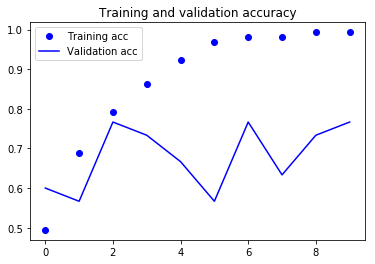

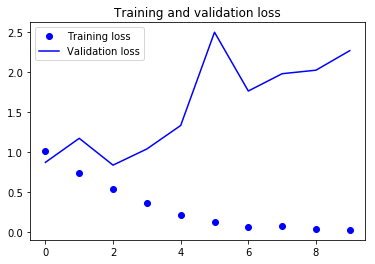

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [56]:
model.save('Baseline_CNN_dog_subset_run2.h5')

In [57]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  shuffle=False)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
y_hat_test = model.predict_generator(test_generator, steps=54)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

Found 30 images belonging to 3 classes.
Generated 810 predictions
test acc: 0.7333333492279053


## Loading a Pretrained CNN

## Feature Engineering with the Pretrained Model

As you may well have guessed, adapting a pretrained model will undoubtedly produce better results then a fresh CNN due to the limited size of training data. Import a pretrained model such as VGG-19 to use a convolutional base. Use this to transform the dataset into a rich feature space and add a few fully connected layers on top of the pretrained layers to build a classification model. (Be sure to leave the pretrained model frozen!)

In [5]:
# Your code here; add fully connected layers on top of the convolutional base
# from keras.preprocessing.image import ImageDataGenerator, array_to_img

# Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(240, 240, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

cnn_base.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model.trainable_weights))

model.summary()

vgg19 False
flatten_1 True
dense_1 True
dense_2 True
dense_3 True
dense_4 True
dense_5 True
10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_______________________________________________

In [10]:
# Preprocessing/Problem Setup
new_root_dir = 'data_org_subset/'

train_dir = '{}train'.format(new_root_dir)
validation_dir = '{}val/'.format(new_root_dir)
test_dir = '{}test/'.format(new_root_dir)

original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Define Initial Parameters (same as previous code block)
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

# Get all the data in the directory split/train (542 images), and reshape them
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(240, 240), 
                                                    batch_size= 20,
                                                    class_mode='categorical') 

# Get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, 
                                                                       target_size=(240, 240), 
                                                                       batch_size=20,
                                                                       class_mode='categorical')

# Get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, 
                                                                        target_size=(240, 240), 
                                                                        batch_size=180,
                                                                        class_mode='categorical',
                                                                        shuffle=False)

        
test_images, test_labels = next(test_generator)


# Compilation
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# Fitting the Model
history = model.fit_generator(train_generator,
                              steps_per_epoch=8,
                              epochs=4,
                              validation_data=val_generator,
                              validation_steps=10)


end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Found 233 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/4
8/8 [==============================] - 194s 24s/step - loss: 0.8701 - acc: 0.6687 - val_loss: 0.7506 - val_acc: 0.8000
Epoch 2/4
8/8 [==============================] - 201s 25s/step - loss: 0.7917 - acc: 0.7493 - val_loss: 0.7195 - val_acc: 0.8000
Epoch 3/4
8/8 [==============================] - 188s 23s/step - loss: 0.7798 - acc: 0.7242 - val_loss: 0.7183 - val_acc: 0.7333
Epoch 4/4
8/8 [==============================] - 189s 24s/step - loss: 0.7497 - acc: 0.7437 - val_loss: 0.6762 - val_acc: 0.8000
Training took a total of 0:12:52.680602


## Visualize History

Now fit the model and visualize the training and validation accuracy/loss functions over successive epochs.

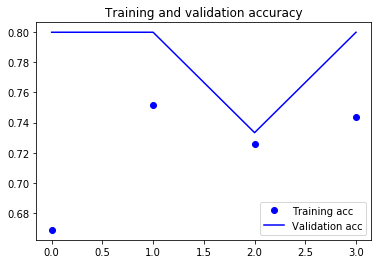

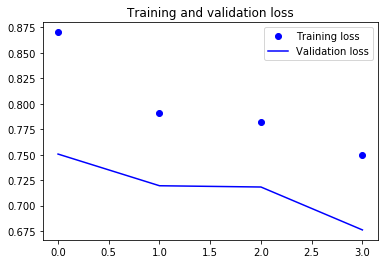

In [11]:
# Your code here; visualize the training / validation history associated with fitting the model

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
# Save model
model.save('vgg19_3breeds_4epochs.h5')

In [31]:
import pickle

with open('history_vgg19__3breeds_4epochs.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Final Model Evaluation

Now that you've trained and validated the model, perform a final evaluation of the model on the test set.

In [15]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(240, 240),
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  shuffle=False)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
y_hat_test = model.predict_generator(test_generator, steps=54)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

Found 30 images belonging to 3 classes.
Generated 810 predictions
test acc: 0.7086419760261053


## Summary

Congratulations! In this lab, you brought all of your prior deep learning skills together from preprocessing including one-hot encoding, to adapting a pretrained model. There are always ongoing advancements in CNN architectures and best practices, but you have a solid foundation and understanding at this point.